In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

import datetime as datetime
import matplotlib.dates as dates
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import datetime
from datetime import date


In [2]:
df=pd.read_csv('/content/covid_19_indonesia_time_series_all.csv.zip')
df.head(20)

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,...,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Total Deaths per 100rb,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
0,3/1/2020,ID-JK,DKI Jakarta,2,0,0,2,39,20,75,...,-6.204699,0.18,3.60,0.00,1.84,0.18,51.28%,192.31%,NaN,NaN
1,3/2/2020,ID-JK,DKI Jakarta,2,0,0,2,41,20,75,...,-6.204699,0.18,3.78,0.00,1.84,0.18,48.78%,182.93%,1.0,1.0
2,3/2/2020,IDN,Indonesia,2,0,0,2,2,0,0,...,-0.789275,0.01,0.01,0.00,0.00,0.00,0.00%,0.00%,NaN,NaN
3,3/2/2020,ID-RI,Riau,1,0,0,1,1,0,1,...,0.511648,0.16,0.16,0.00,0.00,0.00,0.00%,100.00%,NaN,NaN
4,3/3/2020,ID-JK,DKI Jakarta,2,0,0,2,43,20,75,...,-6.204699,0.18,3.96,0.00,1.84,0.18,46.51%,174.42%,1.0,1.0
5,3/3/2020,IDN,Indonesia,0,0,0,0,2,0,0,...,-0.789275,0.00,0.01,0.00,0.00,0.00,0.00%,0.00%,0.0,1.0
6,3/3/2020,ID-JB,Jawa Barat,1,1,0,0,1,1,60,...,-6.920432,0.02,0.02,0.02,0.02,0.00,100.00%,6000.00%,NaN,NaN
7,3/3/2020,ID-RI,Riau,0,0,0,0,1,0,1,...,0.511648,0.00,0.16,0.00,0.00,0.00,0.00%,100.00%,0.0,1.0
8,3/4/2020,ID-JK,DKI Jakarta,2,0,0,2,45,20,75,...,-6.204699,0.18,4.15,0.00,1.84,0.18,44.44%,166.67%,1.0,1.0
9,3/4/2020,IDN,Indonesia,0,0,0,0,2,0,0,...,-0.789275,0.00,0.01,0.00,0.00,0.00,0.00%,0.00%,1.0,1.0


In [3]:
df.columns

Index(['Date', 'Location ISO Code', 'Location', 'New Cases', 'New Deaths',
       'New Recovered', 'New Active Cases', 'Total Cases', 'Total Deaths',
       'Total Recovered', 'Total Active Cases', 'Location Level',
       'City or Regency', 'Province', 'Country', 'Continent', 'Island',
       'Time Zone', 'Special Status', 'Total Regencies', 'Total Cities',
       'Total Districts', 'Total Urban Villages', 'Total Rural Villages',
       'Area (km2)', 'Population', 'Population Density', 'Longitude',
       'Latitude', 'New Cases per Million', 'Total Cases per Million',
       'New Deaths per Million', 'Total Deaths per Million',
       'Total Deaths per 100rb', 'Case Fatality Rate', 'Case Recovered Rate',
       'Growth Factor of New Cases', 'Growth Factor of New Deaths'],
      dtype='object')

In [4]:
print('---Location---')
df.Location.unique()

---Location---


array(['DKI Jakarta', 'Indonesia', 'Riau', 'Jawa Barat', 'Banten',
       'Jawa Tengah', 'Sulawesi Tenggara', 'Bali', 'Kalimantan Timur',
       'Daerah Istimewa Yogyakarta', 'Sumatera Utara', 'Jawa Timur',
       'Kepulauan Riau', 'Sulawesi Selatan', 'Jambi', 'Maluku', 'Papua',
       'Maluku Utara', 'Sumatera Selatan', 'Aceh', 'Kalimantan Tengah',
       'Lampung', 'Sulawesi Tengah', 'Sulawesi Utara', 'Sumatera Barat',
       'Papua Barat', 'Kalimantan Utara', 'Sulawesi Barat',
       'Kalimantan Barat', 'Kalimantan Selatan',
       'Kepulauan Bangka Belitung', 'Bengkulu', 'Nusa Tenggara Barat',
       'Nusa Tenggara Timur', 'Gorontalo'], dtype=object)

In [5]:
date2=[]
for item in df['Date']:
    item2=item.split('/')
    month=int(item2[0])
    day=int(item2[1])
    year=int(item2[2])
    date2+=[datetime.date(year,month,day)]
df['Date']=date2
df['Date'] = pd.to_datetime(df['Date'])


In [6]:
df.head()

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,...,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Total Deaths per 100rb,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
0,2020-03-01,ID-JK,DKI Jakarta,2,0,0,2,39,20,75,...,-6.204699,0.18,3.60,0.0,1.84,0.18,51.28%,192.31%,NaN,NaN
1,2020-03-02,ID-JK,DKI Jakarta,2,0,0,2,41,20,75,...,-6.204699,0.18,3.78,0.0,1.84,0.18,48.78%,182.93%,1.0,1.0
2,2020-03-02,IDN,Indonesia,2,0,0,2,2,0,0,...,-0.789275,0.01,0.01,0.0,0.00,0.00,0.00%,0.00%,NaN,NaN
3,2020-03-02,ID-RI,Riau,1,0,0,1,1,0,1,...,0.511648,0.16,0.16,0.0,0.00,0.00,0.00%,100.00%,NaN,NaN
4,2020-03-03,ID-JK,DKI Jakarta,2,0,0,2,43,20,75,...,-6.204699,0.18,3.96,0.0,1.84,0.18,46.51%,174.42%,1.0,1.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31822 entries, 0 to 31821
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         31822 non-null  datetime64[ns]
 1   Location ISO Code            31822 non-null  object        
 2   Location                     31822 non-null  object        
 3   New Cases                    31822 non-null  int64         
 4   New Deaths                   31822 non-null  int64         
 5   New Recovered                31822 non-null  int64         
 6   New Active Cases             31822 non-null  int64         
 7   Total Cases                  31822 non-null  int64         
 8   Total Deaths                 31822 non-null  int64         
 9   Total Recovered              31822 non-null  int64         
 10  Total Active Cases           31822 non-null  int64         
 11  Location Level               31822 non-nu

In [8]:
print('Change Date Datatype')
df['Date'] = pd.to_datetime(df['Date'])

Change Date Datatype


In [9]:
print('clear Nan Value')
nan_df = df[df.isna().any(axis=1)]
nan_df.head(81)
df = df.dropna(how='all')
df.head()

clear Nan Value


,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,...,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Total Deaths per 100rb,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
0,2020-03-01,ID-JK,DKI Jakarta,2,0,0,2,39,20,75,...,-6.204699,0.18,3.60,0.0,1.84,0.18,51.28%,192.31%,NaN,NaN
1,2020-03-02,ID-JK,DKI Jakarta,2,0,0,2,41,20,75,...,-6.204699,0.18,3.78,0.0,1.84,0.18,48.78%,182.93%,1.0,1.0
2,2020-03-02,IDN,Indonesia,2,0,0,2,2,0,0,...,-0.789275,0.01,0.01,0.0,0.00,0.00,0.00%,0.00%,NaN,NaN
3,2020-03-02,ID-RI,Riau,1,0,0,1,1,0,1,...,0.511648,0.16,0.16,0.0,0.00,0.00,0.00%,100.00%,NaN,NaN
4,2020-03-03,ID-JK,DKI Jakarta,2,0,0,2,43,20,75,...,-6.204699,0.18,3.96,0.0,1.84,0.18,46.51%,174.42%,1.0,1.0


In [10]:
print('drop Indonesia row')
cleaned = df.drop(df[df['Location'] == 'Indonesia'].index)

drop Indonesia row


In [11]:
newest = df.drop_duplicates(subset='Location', keep="last")
newest.head()

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,...,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Total Deaths per 100rb,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
31759,2022-09-14,ID-GO,Gorontalo,1,0,0,1,13951,487,13433,...,0.687003,0.85,11816.36,0.00,412.48,41.25,3.49%,96.29%,NaN,1.0
31780,2022-09-14,ID-SR,Sulawesi Barat,1,0,0,1,15601,394,15201,...,-2.461746,0.64,10000.74,0.00,252.57,25.26,2.53%,97.44%,NaN,1.0
31788,2022-09-15,ID-AC,Aceh,20,0,1,19,44038,2223,41713,...,4.225615,3.81,8392.58,0.00,423.65,42.36,5.05%,94.72%,2.50,1.0
31789,2022-09-15,ID-BA,Bali,38,1,6,31,166831,4731,161629,...,-8.369472,9.01,39569.32,0.24,1122.11,112.21,2.84%,96.88%,6.33,NaN
31790,2022-09-15,ID-BT,Banten,240,0,32,208,333875,2950,328482,...,-6.456736,22.38,31138.16,0.00,275.13,27.51,0.88%,98.38%,1.83,1.0


In [12]:

newest[newest.Location != 'Jawa Barat'].sort_values(by=['Total Cases'], ascending=False)

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,...,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Total Deaths per 100rb,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
31821,2022-09-16,IDN,Indonesia,2358,27,2997,-666,6405044,157876,6218708,...,-0.789275,8.89,24153.07,0.10,595.34,59.53,2.46%,97.09%,0.89,1.29
31792,2022-09-15,ID-JK,DKI Jakarta,1116,0,58,1058,1412511,15513,1386134,...,-6.204699,102.89,130231.62,0.00,1430.28,143.03,1.10%,98.13%,0.91,0.00
31797,2022-09-15,ID-JT,Jawa Tengah,108,0,2,106,636409,33489,601517,...,-7.259097,2.97,17501.04,0.00,920.94,92.09,5.26%,94.52%,0.88,0.00
31798,2022-09-15,ID-JI,Jawa Timur,268,0,43,225,601545,31764,569003,...,-7.723346,6.62,14860.66,0.00,784.70,78.47,5.28%,94.59%,5.06,0.00
31790,2022-09-15,ID-BT,Banten,240,0,32,208,333875,2950,328482,...,-6.456736,22.38,31138.16,0.00,275.13,27.51,0.88%,98.38%,1.83,1.00
31793,2022-09-15,ID-YO,Daerah Istimewa Yogyakarta,27,0,0,27,224307,5928,217712,...,-7.894502,7.44,61775.29,0.00,1632.60,163.26,2.64%,97.06%,2.25,1.00
31802,2022-09-15,ID-KI,Kalimantan Timur,26,0,9,17,209017,5726,203022,...,0.453858,7.32,58841.71,0.00,1611.96,161.20,2.74%,97.13%,2.89,1.00
31789,2022-09-15,ID-BA,Bali,38,1,6,31,166831,4731,161629,...,-8.369472,9.01,39569.32,0.24,1122.11,112.21,2.84%,96.88%,6.33,NaN
31820,2022-09-15,ID-SU,Sumatera Utara,50,0,5,45,158866,3288,154924,...,2.191894,3.36,10680.15,0.00,221.04,22.10,2.07%,97.52%,1.92,1.00
31813,2022-09-15,ID-RI,Riau,19,0,1,18,152648,4452,147973,...,0.511648,3.13,25130.97,0.00,732.95,73.29,2.92%,96.94%,1.19,1.00


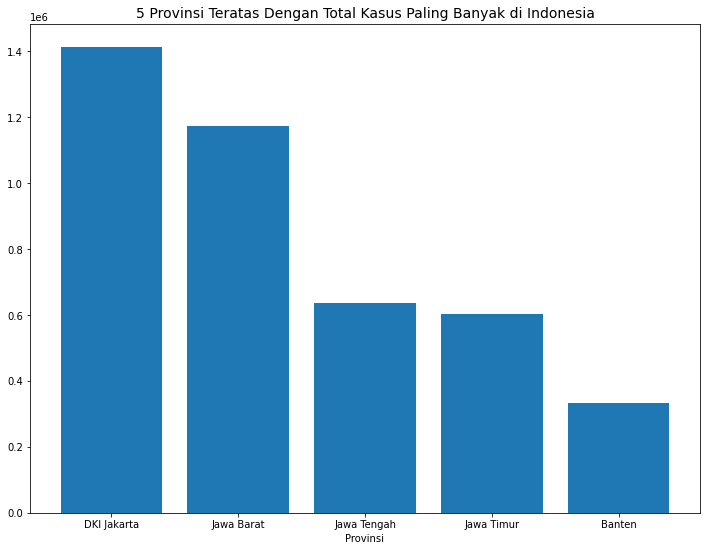

In [13]:
plt.figure(figsize=(12,9))
plt.bar(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], 
                                      ascending=False)['Location'].values[:5], 
        newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], 
                                  ascending=False)['Total Cases'].values[:5])
plt.title('5 Provinsi Teratas Dengan Total Kasus Paling Banyak di Indonesia', fontsize=14)
plt.xlabel('Provinsi')
plt.show()

In [ ]:
Chart diatas menunjukan bahwa DKI Jakarta menempati peringkat tertinggi dalam total kasus covid 19.
Dibandingkan dengan peringkat 2, DKI jauh mengungguli dengan 30% jumlah kasus dari 1 tingkat dibawahnya yaitu Jawa Barat.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


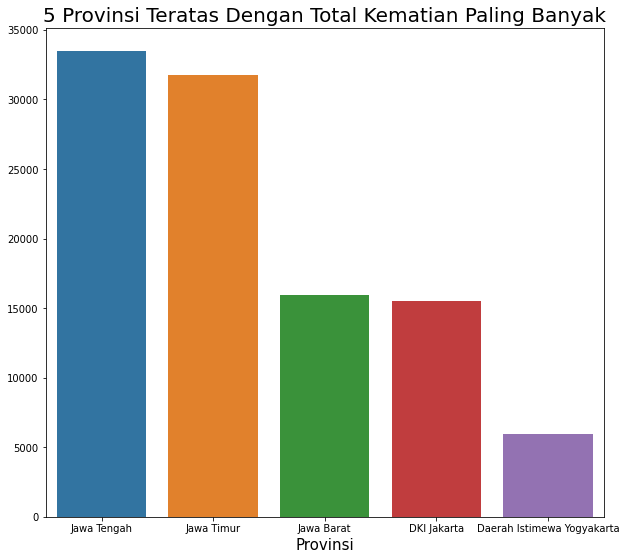

In [14]:
#Provinsi dengan Angka Kematian Terbanyak
plt.figure(figsize=(10,9))
sns.barplot(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Deaths'], 
            ascending=False)['Location'].values[:5], newest[newest.Location != 'Indonesia'].sort_values(by=
           ['Total Deaths'],ascending=False)['Total Deaths'].values[:5])
plt.title('5 Provinsi Teratas Dengan Total Kematian Paling Banyak', fontsize=20)
plt.xlabel('Provinsi', fontsize=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


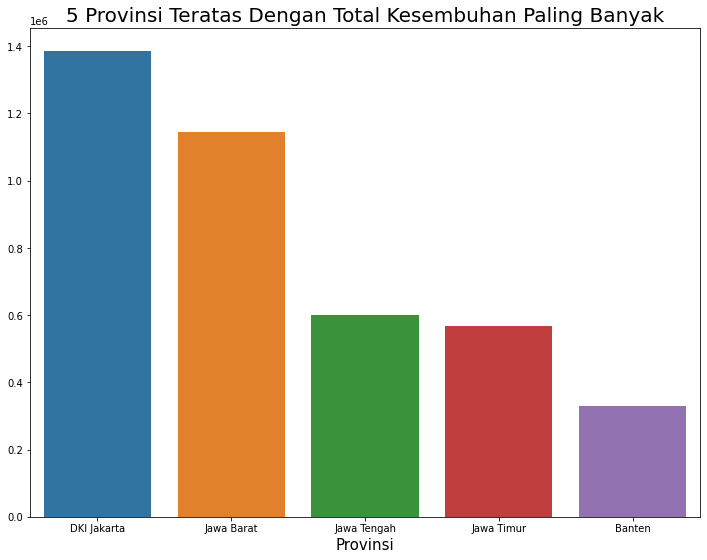

In [15]:
#Provinsi dengan Angka Kesembuhan Terbanyak
plt.figure(figsize=(12,9))
sns.barplot(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Recovered'], ascending=False)['Location'].values[:5],  
            newest[newest.Location != 'Indonesia'].sort_values(by=['Total Recovered'], ascending=False)['Total Recovered'].values[:5])
plt.title('5 Provinsi Teratas Dengan Total Kesembuhan Paling Banyak', fontsize=20)
plt.xlabel('Provinsi', fontsize=15)
plt.show()

In [16]:
Lampung = df[df.Location == 'Lampung'].tail(7).copy()
Lampung

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,...,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Total Deaths per 100rb,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
31597,2022-09-09,ID-LA,Lampung,19,0,9,10,75417,4186,70926,...,-4.916793,2.09,8291.60,0.0,460.22,46.02,5.55%,94.05%,0.54,1.0
31632,2022-09-10,ID-LA,Lampung,26,0,6,20,75443,4186,70932,...,-4.916793,2.86,8294.46,0.0,460.22,46.02,5.55%,94.02%,1.37,1.0
31667,2022-09-11,ID-LA,Lampung,17,0,16,1,75460,4186,70948,...,-4.916793,1.87,8296.33,0.0,460.22,46.02,5.55%,94.02%,0.65,1.0
31702,2022-09-12,ID-LA,Lampung,1,0,124,-123,75461,4186,71072,...,-4.916793,0.11,8296.44,0.0,460.22,46.02,5.55%,94.18%,0.06,1.0
31737,2022-09-13,ID-LA,Lampung,1,0,0,1,75462,4186,71072,...,-4.916793,0.11,8296.55,0.0,460.22,46.02,5.55%,94.18%,1.00,1.0
31772,2022-09-14,ID-LA,Lampung,2,0,0,2,75464,4186,71072,...,-4.916793,0.22,8296.77,0.0,460.22,46.02,5.55%,94.18%,2.00,1.0
31806,2022-09-15,ID-LA,Lampung,21,0,1,20,75485,4186,71073,...,-4.916793,2.31,8299.08,0.0,460.22,46.02,5.55%,94.16%,10.50,1.0


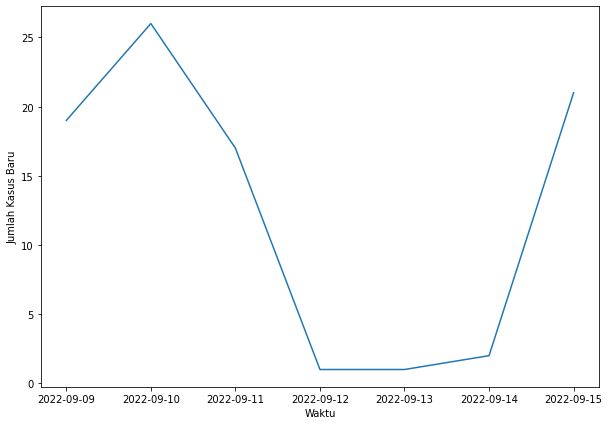

In [17]:
plt.figure(figsize=(10,7))
plt.plot(Lampung['Date'].values ,Lampung['New Cases'].values)
plt.xlabel('Waktu')
plt.ylabel('Jumlah Kasus Baru')
plt.show()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print('Persentase Kenaikan dari Tanggal 12-14 sebanyak', (Lampung['New Cases'].values[4:][1]- Lampung['New Cases'].values[4:][0]) / Lampung['New Cases'].values[4:][0] * 100)

Persentase Kenaikan dari Tanggal 12-14 sebanyak 100.0


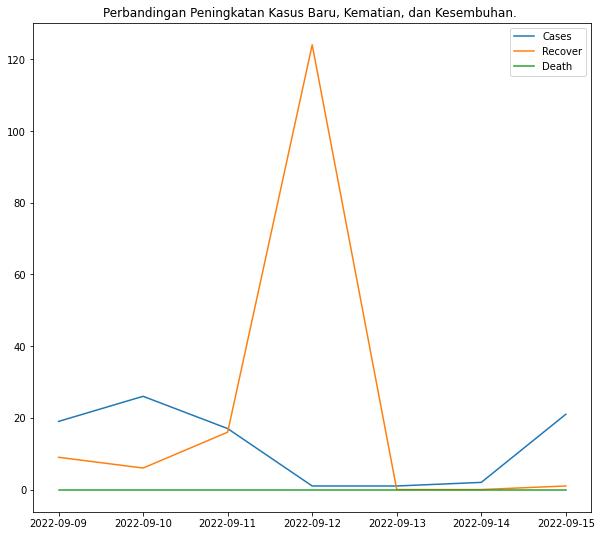

In [18]:
plt.figure(figsize=(10,9))
plt.plot(Lampung['Date'].values ,Lampung['New Cases'].values, label='Cases')
plt.plot(Lampung['Date'].values, Lampung['New Recovered'].values, label = 'Recover')
plt.plot(Lampung['Date'].values, Lampung['New Deaths'].values, label = 'Death')
plt.title('Perbandingan Peningkatan Kasus Baru, Kematian, dan Kesembuhan. ')
plt.legend()
plt.show()

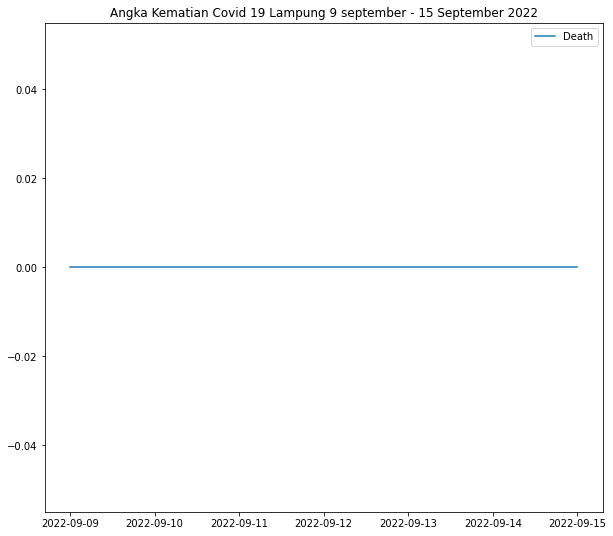

In [ ]:
plt.figure(figsize=(10,9))
plt.plot(Lampung['Date'].values, Lampung['New Deaths'].values, label = 'Death')
plt.title('Angka Kematian Covid 19 Lampung 9 september - 15 September 2022')
plt.legend()
plt.show()

In [ ]:
sumsel = df[df.Location == 'Sumatera Selatan'].tail(7).copy()
sumsel

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,...,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Total Deaths per 100rb,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
31611,2022-09-09,ID-SS,Sumatera Selatan,18,0,43,-25,82133,3373,78427,...,-3.216212,2.19,9994.83,0.00,410.46,41.05,4.11%,95.49%,0.78,1.0
31646,2022-09-10,ID-SS,Sumatera Selatan,23,0,23,0,82156,3373,78450,...,-3.216212,2.80,9997.63,0.00,410.46,41.05,4.11%,95.49%,1.28,1.0
31681,2022-09-11,ID-SS,Sumatera Selatan,17,1,26,-10,82173,3374,78476,...,-3.216212,2.07,9999.69,0.12,410.58,41.06,4.11%,95.50%,0.74,NaN
31716,2022-09-12,ID-SS,Sumatera Selatan,2,1,29,-28,82175,3375,78505,...,-3.216212,0.24,9999.94,0.12,410.71,41.07,4.11%,95.53%,0.12,1.0
31751,2022-09-13,ID-SS,Sumatera Selatan,2,1,3,-2,82177,3376,78508,...,-3.216212,0.24,10000.18,0.12,410.83,41.08,4.11%,95.54%,1.00,1.0
31786,2022-09-14,ID-SS,Sumatera Selatan,5,0,1,4,82182,3376,78509,...,-3.216212,0.61,10000.79,0.00,410.83,41.08,4.11%,95.53%,2.50,0.0
31819,2022-09-15,ID-SS,Sumatera Selatan,16,0,1,15,82198,3376,78510,...,-3.216212,1.95,10002.74,0.00,410.83,41.08,4.11%,95.51%,3.20,1.0


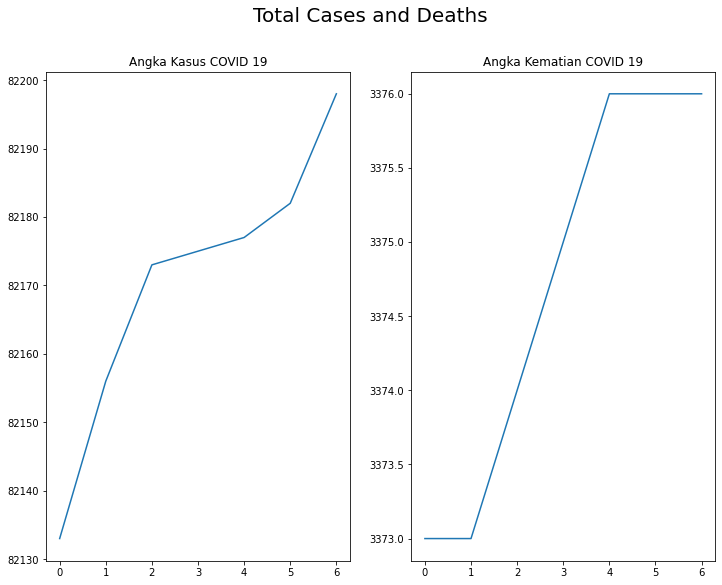

In [ ]:
fig,(ax1,ax2) =  plt.subplots(1,2,figsize=(12,9))
ax1.plot(range(7), sumsel['Total Cases'].values)
ax1.set_title('Angka Kasus COVID 19')
ax2.plot(range(7), sumsel['Total Deaths'].values)
ax2.set_title('Angka Kematian COVID 19')
plt.suptitle('Total Cases and Deaths', fontsize=20)
plt.show()

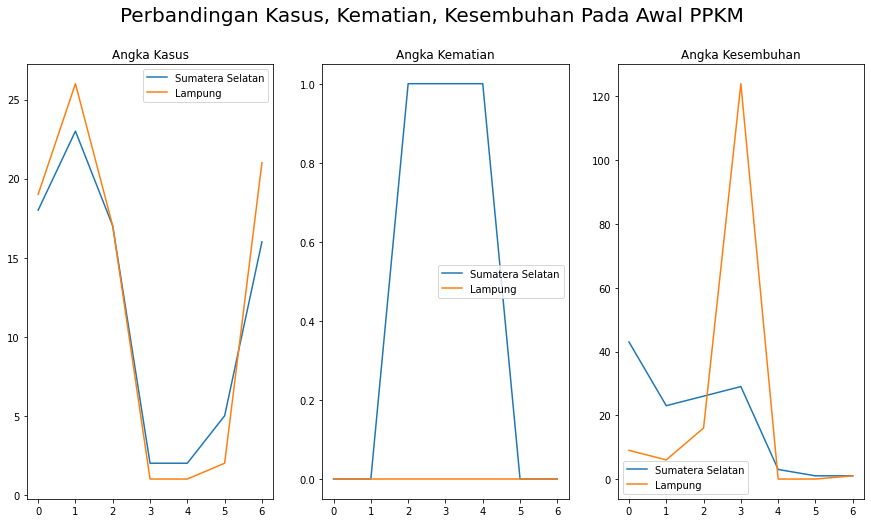

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,8))
fig.suptitle('Perbandingan Kasus, Kematian, Kesembuhan Pada Awal PPKM', fontsize=20)
ax[0].plot(range(7), sumsel['New Cases'].values, label = 'Sumatera Selatan')
ax[0].plot(range(7), Lampung['New Cases'].values, label = 'Lampung')
ax[0].set_title('Angka Kasus')
ax[0].legend()
ax[1].plot(range(7), sumsel['New Deaths'].values, label = 'Sumatera Selatan')
ax[1].plot(range(7), Lampung['New Deaths'].values, label = 'Lampung')
ax[1].set_title('Angka Kematian')
ax[1].legend()
ax[2].plot(range(7), sumsel['New Recovered'].values, label = 'Sumatera Selatan')
ax[2].plot(range(7), Lampung['New Recovered'].values, label = 'Lampung')
ax[2].set_title('Angka Kesembuhan')
ax[2].legend()
plt.show()